In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Funciones de ingeniería de características.

In [9]:
def add_categ_range_col(df, col, method='quantile',
                        thresholds=None, labels=('bajo','medio','alto')):
    """
    Agrega columna '{col}_range' con categorías (bajo/medio/alto).
    - method: 'quantile' usa cuantiles [0, .5, 1] si thresholds es None.
    - thresholds: lista de bin edges [min, t1, t2, max].
    """
    series = df[col]
    if thresholds is None and method=='quantile':
        q = series.quantile([0, .33, .66, 1]).values
        bins = q
    else:
        bins = thresholds
    df[f'{col}_range'] = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return df

def add_pareto_front(df, x='time_duration', y='total_reward',
                     minimize_x=True, maximize_y=True,
                     labels=('front_1','front_2','front_3')):
    """
    Aplica non-dominated sorting para hasta 3 fronts.
    Crea columna 'pareto_label' con etiqueta de front.
    """
    data = df[[x, y]].values
    n = data.shape[0]
    fronts = []
    dominated = np.zeros(n, dtype=bool)
    for level in range(len(labels)):
        mask = np.zeros(n, dtype=bool)
        for i in range(n):
            if dominated[i]: continue
            better = False
            for j in range(n):
                if i==j or dominated[j]: continue
                xi, yi = data[i]
                xj, yj = data[j]
                # comparar según objetivos
                better_x = (xj < xi) if minimize_x else (xj > xi)
                better_y = (yj > yi) if maximize_y else (yj < yi)
                if better_x and better_y:
                    dominated[i] = True
                    break
            else:
                mask[i] = True
        fronts.append(mask)
        dominated |= mask
        if dominated.all():
            break

    df['pareto_label'] = None
    for lvl, mask in enumerate(fronts):
        df.loc[mask, 'pareto_label'] = labels[lvl]
    return df

def add_round_gains(df, discrete_range=np.arange(0, 5.5, 0.5)):
    """
    Redondea final_kp, final_ki, final_kd al valor más cercano de discrete_range.
    Crea columnas 'kp_round', 'ki_round', 'kd_round'.
    """
    def nearest(val):
        idx = np.abs(discrete_range - val).argmin()
        return discrete_range[idx]
    df['kp_round'] = df['final_kp'].apply(nearest)
    df['ki_round'] = df['final_ki'].apply(nearest)
    df['kd_round'] = df['final_kd'].apply(nearest)
    return df

def top_n_combinations(df, suffix_name='reward_and_time',
                       sort_by=('total_reward','time_duration'),
                       ascending=(False, True), n=10):
    """
    Asigna ranking global basado en sort_by:
    - ascending tuple: True=ascendente, False=descendente.
    Agrega columna 'rank_{suffix_name}' y devuelve top n rows.
    """
    col_rank = f'rank_{suffix_name}'
    df_sorted = df.sort_values(list(sort_by), ascending=list(ascending)).copy()
    df_sorted[col_rank] = np.arange(1, len(df_sorted)+1)
    return df_sorted.head(n)

In [62]:
# Tablas resumenes.

def summary_by_range(df, group_categ_col='pareto_label', add_col_freq=True,
                     base_name='freq_', suffix_name='pareto'):
    """
    Genera tabla con frecuencias y estadísticos por grupo categórico:
      - count, mean, std, min, 25%, 50%, 75%, max
    Si add_col_freq=True, agrega columna de frecuencia en df original.
    """
    import numpy as np
    import pandas as pd

    # Frecuencia por grupo
    freq = df.groupby(group_categ_col).size().rename(f"{base_name}{suffix_name}")

    # Estadísticos sobre columnas numéricas
    numeric_cols = df.select_dtypes(include=np.number).columns
    agg_funcs = [
        'count', 'mean', 'std', 'min',
        lambda x: x.quantile(.25), 'median',
        lambda x: x.quantile(.75), 'max'
    ]
    agg_names = ['count','mean','std','min','25%','50%','75%','max']

    stats = df.groupby(group_categ_col)[numeric_cols].agg(agg_funcs)
    # Renombrar columnas
    stats.columns = [
        f"{col}_{name}"
        for col in numeric_cols
        for name in agg_names
    ]

    # Unir frecuencia y estadísticas
    summary = pd.concat([freq, stats], axis=1)

    # Agregar columna de frecuencia al DataFrame original
    if add_col_freq:
        df[f"{base_name}{suffix_name}"] = df[group_categ_col].map(freq)

    return summary

# Funciones para visualización

In [22]:
plot_config = {
    'figsize': (14, 10),    # tamaño de la figura
    'tick_fontsize': 12,   # tamaño fuente ticks
    'xtick_rotation': 0,  # rotación etiquetas eje X
    'palette': 'deep',     # paleta seaborn
    'grid_on': True,       # mostrar grid
    'save_path': '1_paper_results/'   # ruta para guardar figuras
}

In [76]:
def plot_pairplot(df, vars_list, hue=None, config=plot_config, save_fig=False):
    """Scatter matrix con seaborn.pairplot"""
    sns.set_palette(config['palette'])
    g = sns.pairplot(df, vars=vars_list, hue=hue)
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(),
                 rotation=config['xtick_rotation'],
                 fontsize=config['tick_fontsize'])
    if save_fig:
        g.savefig(f"{config['save_path']}pairplot.png", bbox_inches='tight')
    plt.show()

def plot_3d_scatter(df, x='final_kp', y='final_ki', z='final_kd',
                    color='total_reward', marker_by=None,
                    config=plot_config, save_fig=False):
    """Gráfico 3D con color continuo y posibilidad de marcador por categoría"""
    title = '3D Scatter of gains combinations with total reward as color'
    xlabel = 'K_p'
    ylabel = 'K_i'
    zlabel = 'K_d'
    fig = plt.figure(figsize=config['figsize'])
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(df[x], df[y], df[z], c=df[color], cmap='hot')
    if marker_by:
        for m in df[marker_by].unique():
            idx = df[marker_by] == m
            ax.scatter(df.loc[idx, x], df.loc[idx, y], df.loc[idx, z], label=m)
        ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)
    ax.set_zlabel(zlabel or z)
    if save_fig:
        fig.savefig(f"{config['save_path']}3d_scatter.png", bbox_inches='tight')
    plt.show()

def plot_pareto(df, x='time_duration', y='total_reward',
                minimize_x=True, maximize_y=True,
                highlight_color='red', config=plot_config, save_fig=False):
    """Dibuja puntos y resalta primer frente de Pareto"""
    title = 'Time duration vs Total reward'
    xlabel = 'Time duration [-]'
    ylabel = 'Total reward [-]'
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.scatter(df[x], df[y], label='Todos los puntos')
    front = df[df['pareto_label'] == 'front_1']
    ax.scatter(front[x], front[y], color=highlight_color, label='Frontera Pareto')
    ax.set_title(title)
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)
    if config['grid_on']:
        ax.grid(True)
    ax.legend()
    if save_fig:
        fig.savefig(f"{config['save_path']}pareto.png", bbox_inches='tight')
    plt.show()

# Carga y preparación de datos.

In [29]:
# 1. Leer Excel
df_raw = pd.read_excel('results_history_CartPole\\20250730-1228\\episodes_summary_data.xlsx')
print(f"Tamaño del DataFrame: {df_raw.shape}")
display(df_raw.head())
print("Columnas:", list(df_raw.columns))

Tamaño del DataFrame: (5000, 157)


,episode,episode_wall_time_sec,epsilon,learning_rate,total_agent_decisions,time_duration,termination_reason,total_reward,performance,avg_stability_score,...,reward_level_ratep75,reward_levelp25,reward_levelp50,reward_levelp75,stability_score_max,stability_score_mean,stability_score_min,stability_scorep25,stability_scorep50,stability_scorep75
0,0,0.151562,0.999425,0.998850,180,1.799,limit_exceeded,751.114468,417.517770,0.015449,...,NaN,NaN,NaN,NaN,0.180577,0.015449,1.526108e-99,1.680488e-29,3.155635e-08,0.002346
1,1,0.158936,0.998849,0.997701,196,1.952,limit_exceeded,882.976451,452.344493,0.020452,...,NaN,NaN,NaN,NaN,0.180547,0.020452,2.005171e-96,5.010072e-26,1.435356e-10,0.006241
2,2,0.107207,0.998275,0.996554,135,1.349,limit_exceeded,849.615778,629.811548,0.020295,...,NaN,NaN,NaN,NaN,0.180545,0.020295,6.605556e-114,2.999932e-49,3.140604e-14,0.003579
3,3,0.111451,0.997700,0.995408,132,1.314,limit_exceeded,881.216199,670.636377,0.021628,...,NaN,NaN,NaN,NaN,0.180581,0.021628,1.210353e-154,9.437019e-40,1.367799e-14,0.004593
4,4,0.154023,0.997126,0.994263,197,1.964,limit_exceeded,670.920004,341.608963,0.011571,...,NaN,NaN,NaN,NaN,0.180546,0.011571,5.044043e-70,2.714779e-23,9.152186e-14,0.000013


Columnas: ['episode', 'episode_wall_time_sec', 'epsilon', 'learning_rate', 'total_agent_decisions', 'time_duration', 'termination_reason', 'total_reward', 'performance', 'avg_stability_score', 'final_kp', 'final_ki', 'final_kd', 'avg_stability_score_interval_max', 'avg_stability_score_interval_mean', 'avg_stability_score_interval_min', 'avg_stability_score_intervalp25', 'avg_stability_score_intervalp50', 'avg_stability_score_intervalp75', 'cart_force_max', 'cart_force_mean', 'cart_force_min', 'cart_forcep25', 'cart_forcep50', 'cart_forcep75', 'cart_position_max', 'cart_position_mean', 'cart_position_min', 'cart_positionp25', 'cart_positionp50', 'cart_positionp75', 'cart_velocity_max', 'cart_velocity_mean', 'cart_velocity_min', 'cart_velocityp25', 'cart_velocityp50', 'cart_velocityp75', 'control_action_max', 'control_action_mean', 'control_action_min', 'control_actionp25', 'control_actionp50', 'control_actionp75', 'd_term_max', 'd_term_mean', 'd_term_min', 'd_termp25', 'd_termp50', 'd_t

In [31]:
# 2. Selección de columnas de interés
cols = ['episode', 'epsilon', 'learning_rate',
        'time_duration', 'termination_reason',
        'total_reward', 'final_kp', 'final_ki', 'final_kd']
df = df_raw[cols].copy()
df.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration',
       'termination_reason', 'total_reward', 'final_kp', 'final_ki',
       'final_kd'],
      dtype='object')

In [35]:
# 3. Estadísticos generales
print("Estadísticos globales:")
display(df.describe().T)

Estadísticos globales:


,count,mean,std,min,25%,50%,75%,max
episode,5000.0,2499.500000,1443.520003,0.000000,1249.750000,2499.500000,3749.250000,4999.000000
epsilon,5000.0,0.332602,0.251536,0.100000,0.115462,0.237070,0.486758,0.999425
learning_rate,5000.0,0.173972,0.237830,0.010000,0.013363,0.056290,0.237120,0.998850
time_duration,5000.0,2.118227,0.432507,1.198000,1.852000,2.115000,2.412000,3.535000
total_reward,5000.0,2974.929361,1858.865382,626.795867,847.547229,3221.274122,4645.270316,6654.299625
final_kp,5000.0,1.873080,0.789357,0.000000,1.400000,2.200000,2.500000,4.900000
final_ki,5000.0,0.302560,0.439896,0.000000,0.100000,0.200000,0.400000,3.600000
final_kd,5000.0,0.773860,0.569645,0.000000,0.400000,0.800000,1.000000,4.400000


In [41]:
# 4. Filtrar solo episodios estabilizados
df_stable = df[df['termination_reason'] == 'goal_reached'].copy()
print(f"Tamaño tras filtrar estabilizados: {df_stable.shape}")
print("Estadísticos solo estabilizados:")
display(df_stable.describe().T)

Tamaño tras filtrar estabilizados: (2162, 9)
Estadísticos solo estabilizados:


,count,mean,std,min,25%,50%,75%,max
episode,2162.0,3894.488899,647.882192,1050.000000,3347.250000,3900.500000,4451.750000,4999.000000
epsilon,2162.0,0.124801,0.033163,0.100000,0.100000,0.105834,0.145525,0.546072
learning_rate,2162.0,0.016699,0.011012,0.010000,0.010000,0.011228,0.021222,0.298393
time_duration,2162.0,2.335906,0.331342,1.692000,2.058250,2.307500,2.573000,3.220000
total_reward,2162.0,4811.116587,661.863297,3546.476148,4237.104298,4714.747056,5266.651026,6654.299625
final_kp,2162.0,2.485939,0.160910,1.900000,2.400000,2.500000,2.600000,3.000000
final_ki,2162.0,0.166189,0.140170,0.000000,0.100000,0.100000,0.300000,1.100000
final_kd,2162.0,0.888483,0.136125,0.400000,0.800000,0.900000,1.000000,1.400000


# Parámetros extras

In [51]:
# 5. Aplicar funciones de ingeniería de características
df2 = df_stable.copy()
#df2 = add_categ_range_col(df2, col='final_kp')
df2 = add_pareto_front(df2, x='time_duration', y='total_reward')
#df2 = add_round_gains(df2)

display(df2.head())

,episode,epsilon,learning_rate,time_duration,termination_reason,total_reward,final_kp,final_ki,final_kd,pareto_label
1050,1050,0.546072,0.298393,2.769,goal_reached,5522.643323,2.0,0.0,0.8,None
2216,2216,0.279094,0.078002,2.916,goal_reached,5849.096817,2.0,0.2,0.6,None
2336,2336,0.260466,0.067942,2.737,goal_reached,5298.234378,1.9,0.1,0.4,None
2338,2338,0.260166,0.067786,2.653,goal_reached,5176.557144,1.9,0.1,0.4,None
2690,2690,0.212447,0.045210,2.298,goal_reached,4576.540802,2.2,0.0,0.7,None


In [53]:
df2['pareto_label'].unique()

array([None, 'front_1'], dtype=object)

# Análisis de Resultados

In [64]:
# 6. Tablas resumen por rango Pareto
summary_pareto = summary_by_range(df2, group_categ_col='pareto_label')
display(summary_pareto)

,freq_pareto,episode_count,episode_mean,episode_std,episode_min,episode_25%,episode_50%,episode_75%,episode_max,epsilon_count,...,final_kd_75%,final_kd_max,freq_pareto_count,freq_pareto_mean,freq_pareto_std,freq_pareto_min,freq_pareto_25%,freq_pareto_50%,freq_pareto_75%,freq_pareto_max
pareto_label,,,,,,,,,,,,,,,,,,,,,
front_1,304,304,4367.917763,465.165938,3193,3929.0,4513.5,4750.25,4999,304,...,1.1,1.2,304,304.0,0.0,304.0,304.0,304.0,304.0,304.0


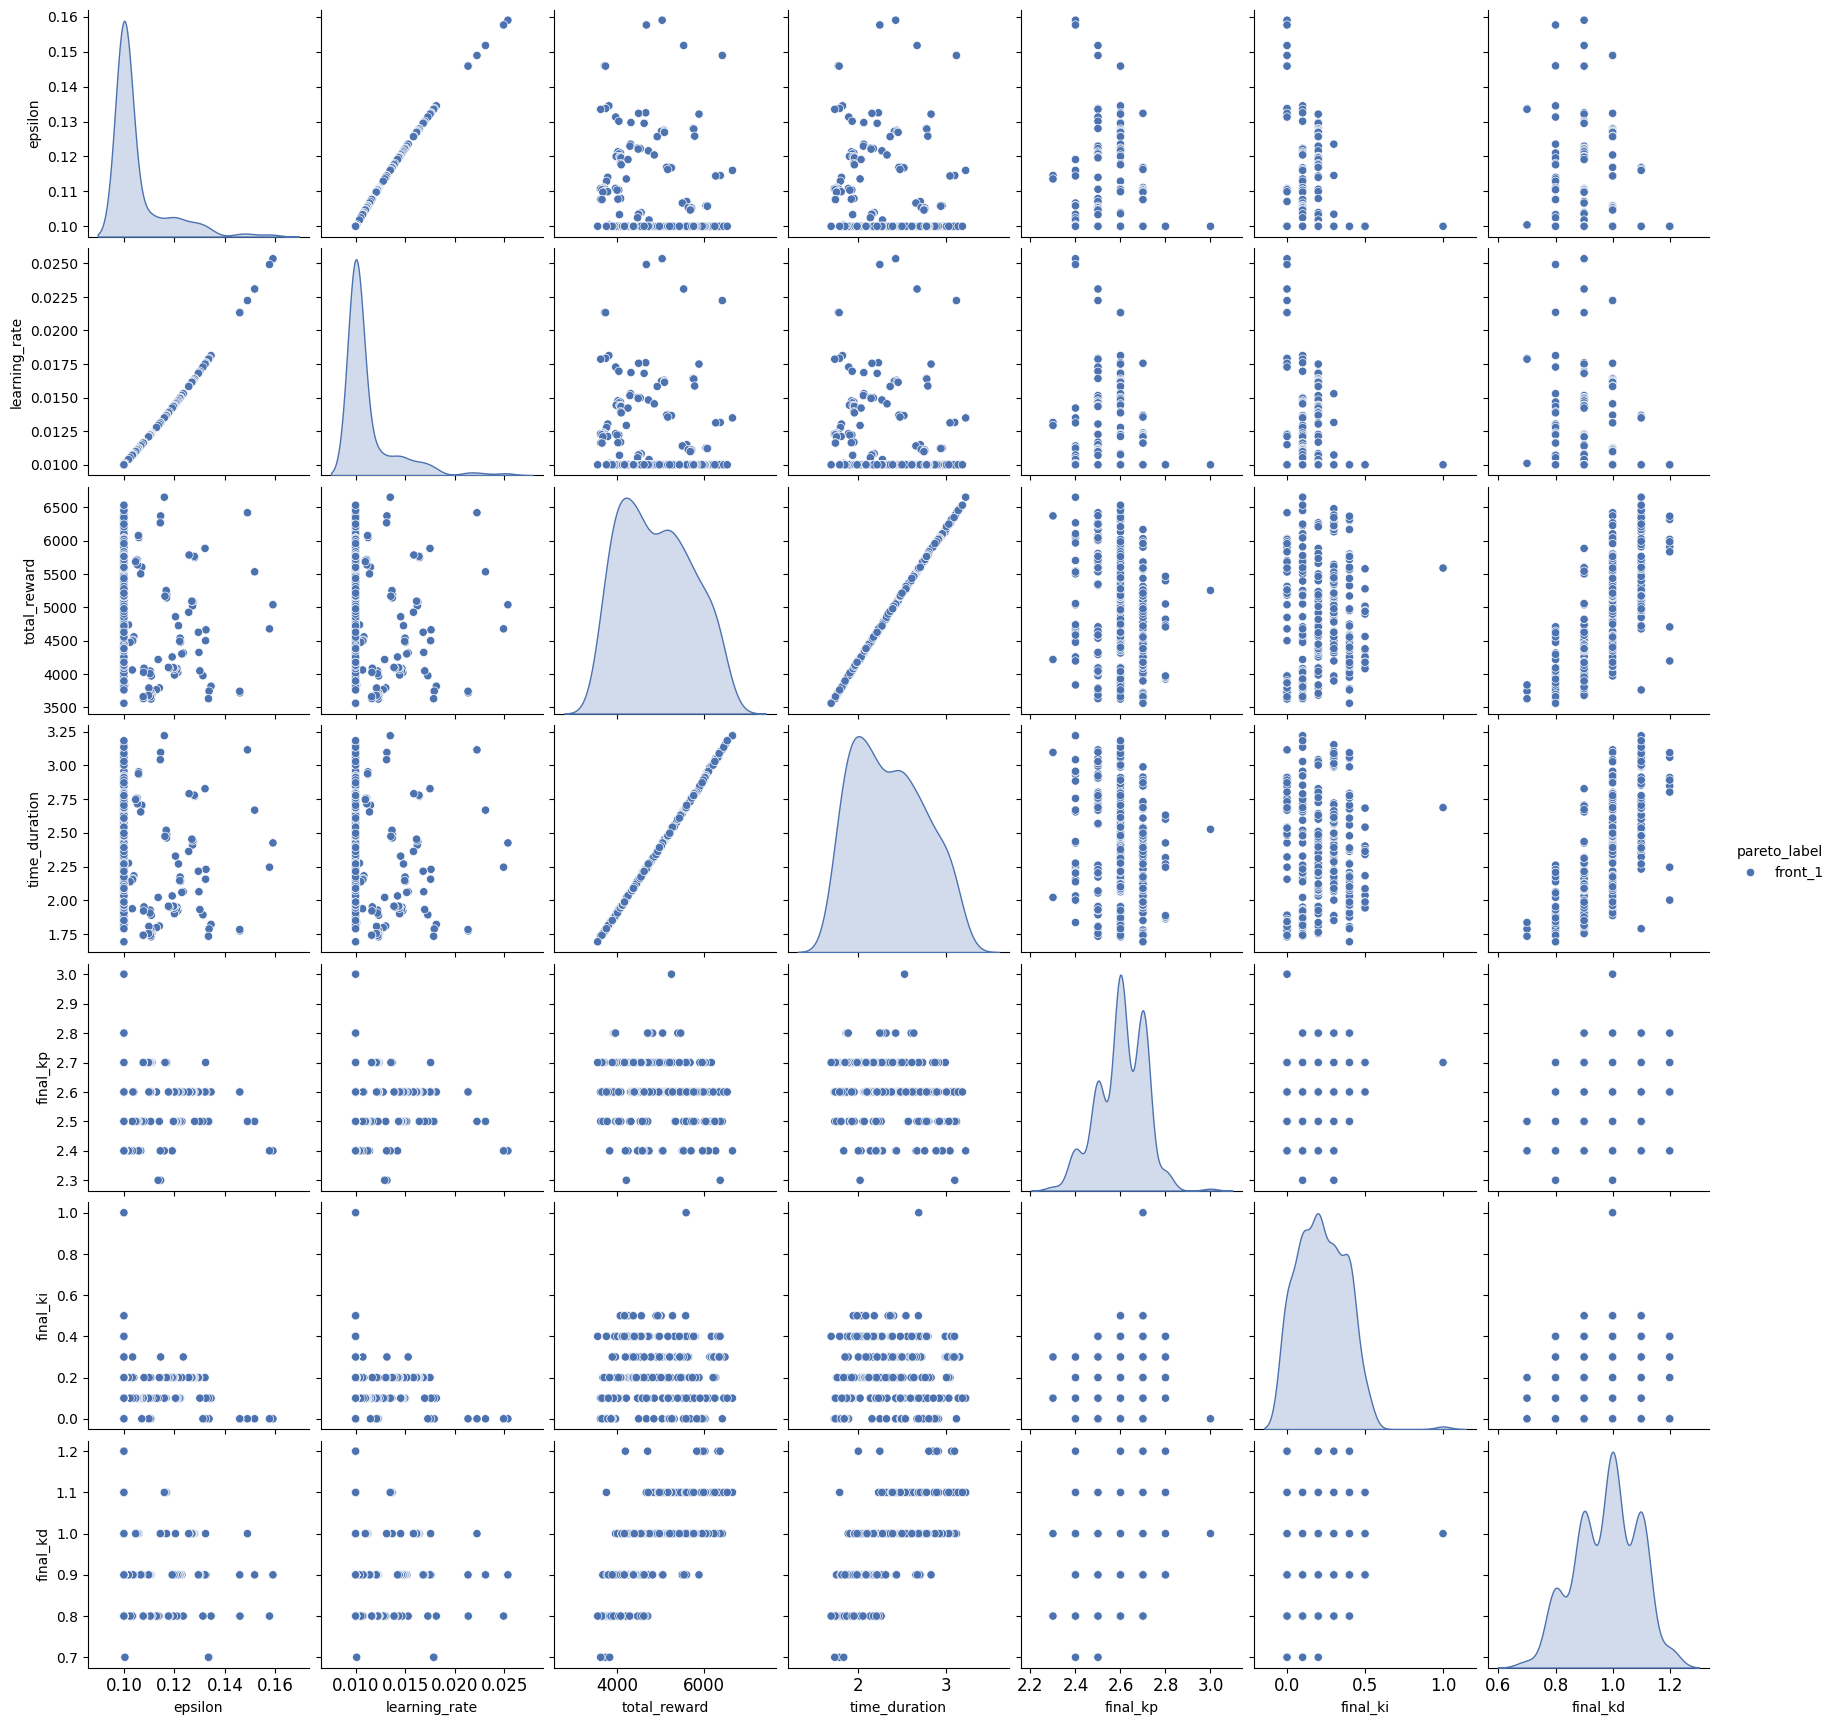

In [66]:
vars_pair = ['epsilon', 'learning_rate', 'total_reward', 'time_duration', 'final_kp', 'final_ki', 'final_kd']
plot_pairplot(df2, vars_list=vars_pair, hue='pareto_label')

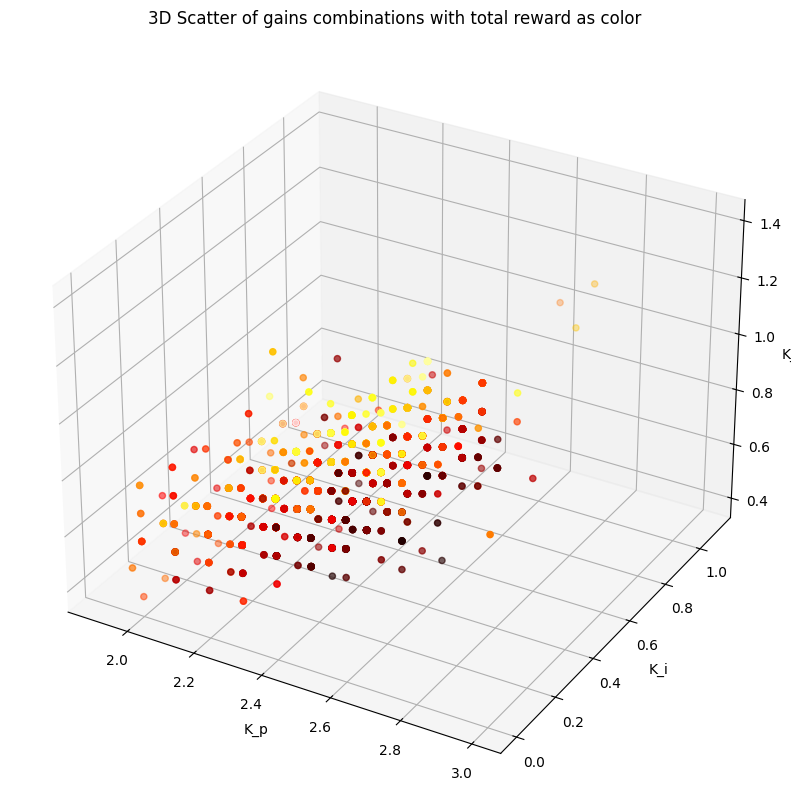

In [78]:
plot_3d_scatter(df2,
                x='final_kp', y='final_ki', z='final_kd',
                color='total_reward',
                marker_by=None)

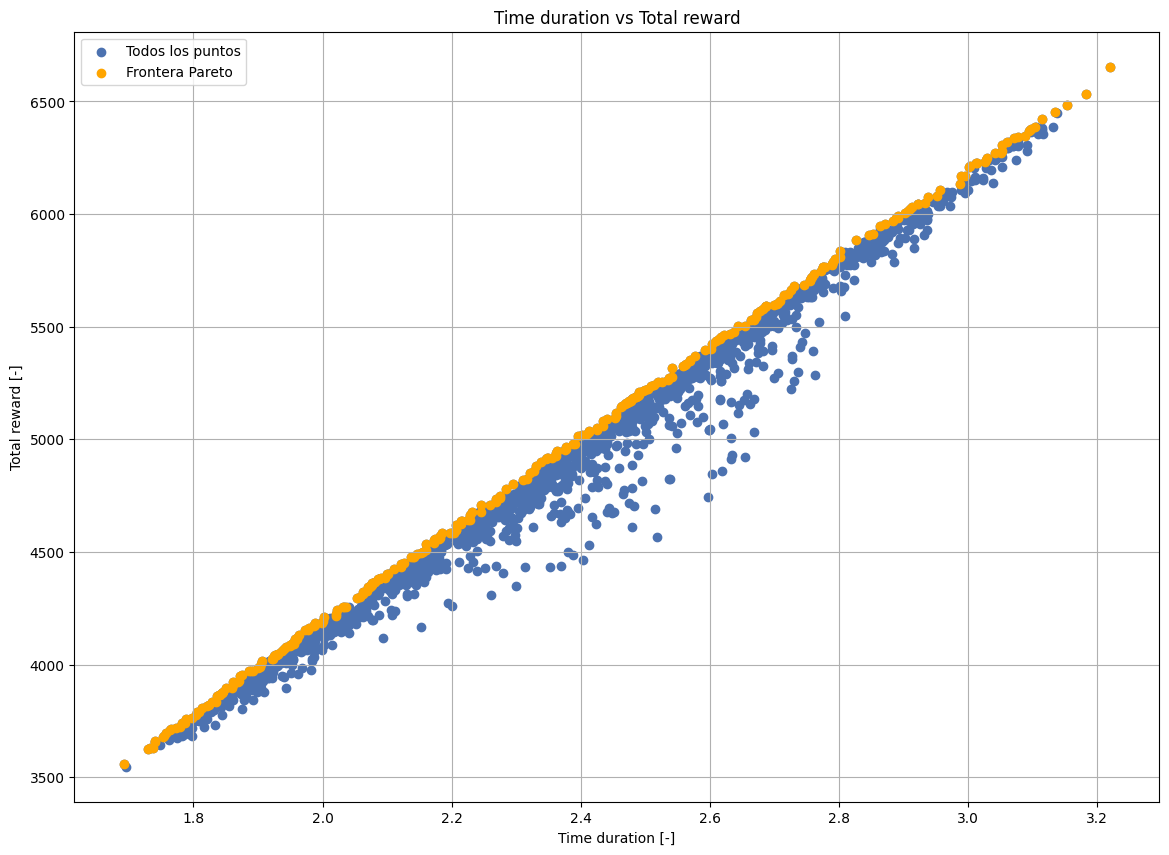

In [80]:
plot_pareto(df2,
            x='time_duration', y='total_reward',
            highlight_color='orange')